## Summary
We implemented a deep neural network to predict human actions by modifying the gait recognition model by Marian Margeta (https://github.com/marian-margeta/gait-recognition). We extracted the spatial features of the human poses of each frame and extract their temporal features by running them through a Recurrent Neural Network. At last, we classify the human actions with a Logistic Regression Model using the temporal features as input. 

Dataset Used:

https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php
- UCF11 Dataset (or UCF Youtube Action Dataset): contains 11 action categories: basketball shooting, biking/cycling, diving, golf swinging, horse back riding, soccer juggling, swinging, tennis swinging, trampoline jumping, volleyball spiking, and walking with a dog.

https://www.crcv.ucf.edu/data/UCF101.php
- UCF101 Dataset: "With 13320 videos from 101 action categories, UCF101 gives the largest diversity in terms of actions and with the presence of large variations in camera motion, object appearance and pose, object scale, viewpoint, cluttered background, illumination conditions, etc, it is the most challenging data set to date."

http://dipersec.kingston.ac.uk/G3D/G3D.html
- D3G Dataset: G3D dataset contains a range of gaming actions captured with Microsoft Kinect. The Kinect enabled us to record synchronised video, depth and skeleton data. The dataset contains 10 subjects performing 20 gaming actions, from which we selected 7 categories: punch right, punch left, kick right, kick left, wave, flap arms and clap.

Results:
We were able to achieve a 94.87% accuracy on D3G dataset, 74.24% accuracy on UCF11 dataset, and 64.55% accuracy on UCF101 dataset.

## Configurations

In [23]:
import os
import cv2
import joblib
import time
import tensorflow as tf
import pandas as pd
import numpy as np
from io import BytesIO
from queue import Queue
from PIL import Image
from ipywidgets import Video
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from human_pose_nn import HumanPoseIRNetwork
from gait_nn import GaitNetwork

In [3]:
# directory of raw data
UCF_11_DATA_DIR = "D:/Data/movement/UCF11_updated_mpg/"
UCF_101_DATA_DIR = "D:/Data/movement/UCF101/"
G3D_DATA_DIR = "D:/Data/movement/basic_action/"

# saved model paths
UCF_11_LOGREG_MODEL_PATH = "models/logreg_ucf_11.sav"
UCF_101_LOGREG_MODEL_PATH = "models/logreg_ucf_101.sav"
G3D_LOGREG_MODEL_PATH = "models/logreg_g3d.sav"

# for data pre-processing
MAX_NUM_FRAME_PER_VIDEO = 200
MAX_NUM_DATA_PER_CATEGORY = 30

In [4]:
UCF_11_CATEGORIES = ["basketball", "diving", "diving", "golf_swing", "horse_riding", "soccer_juggling", "swing", 
              "tennis_swing", "trampoline_jumping", "volleybal_spiking", "walking"]
UCF_101_CATEGORIES = ['ApplyEyeMakeup' 'ApplyLipstick' 'Archery' 'BabyCrawling' 'BalanceBeam'
 'BandMarching' 'BaseballPitch' 'Basketball' 'BasketballDunk' 'BenchPress'
 'Biking' 'Billiards' 'BlowDryHair' 'BlowingCandles' 'BodyWeightSquats'
 'Bowling' 'BoxingPunchingBag' 'BoxingSpeedBag' 'BreastStroke'
 'BrushingTeeth' 'CleanAndJerk' 'CliffDiving' 'CricketBowling'
 'CricketShot' 'CuttingInKitchen' 'Diving' 'Drumming' 'Fencing'
 'FieldHockeyPenalty' 'FloorGymnastics' 'FrisbeeCatch' 'FrontCrawl'
 'GolfSwing' 'Haircut' 'HammerThrow' 'Hammering' 'HandstandPushups'
 'HandstandWalking' 'HeadMassage' 'HighJump' 'HorseRace' 'HorseRiding'
 'HulaHoop' 'IceDancing' 'JavelinThrow' 'JugglingBalls' 'JumpRope'
 'JumpingJack' 'Kayaking' 'Knitting' 'LongJump' 'Lunges' 'MilitaryParade'
 'Mixing' 'MoppingFloor' 'Nunchucks' 'ParallelBars' 'PizzaTossing'
 'PlayingCello' 'PlayingDaf' 'PlayingDhol' 'PlayingFlute' 'PlayingGuitar'
 'PlayingPiano' 'PlayingSitar' 'PlayingTabla' 'PlayingViolin' 'PoleVault'
 'PommelHorse' 'PullUps' 'Punch' 'PushUps' 'Rafting' 'RockClimbingIndoor'
 'RopeClimbing' 'Rowing' 'SalsaSpin' 'ShavingBeard' 'Shotput'
 'SkateBoarding' 'Skiing' 'Skijet' 'SkyDiving' 'SoccerJuggling'
 'SoccerPenalty' 'StillRings' 'SumoWrestling' 'Surfing' 'Swing'
 'TableTennisShot' 'TaiChi' 'TennisSwing' 'ThrowDiscus'
 'TrampolineJumping' 'Typing' 'UnevenBars' 'VolleyballSpiking'
 'WalkingWithDog' 'WallPushups' 'WritingOnBoard' 'YoYo']
G3D_CATEGORIES = ["Clap", "Flap Arms", "Left Kick", "Left Punch", "Right Kick", "Right Punch", "Wave"]

## Data Processing
Process Video and save them as frames

In [3]:
# process video as frames and save them as jpeg
def process_video_frames(index, root, file_path):
    video = cv2.VideoCapture(file_path)
    i = 0
    while i < MAX_NUM_FRAME_PER_VIDEO and video.isOpened():
        ret, frame = video.read()
        if ret == False:
            break
        if not os.path.exists(root + '/' + str(index)):
            os.makedirs(root + '/' + str(index))
        cv2.imwrite(root + '/' + str(index) + '/frame'+str(i)+'.jpg', frame)
        i+=1
    video.release()
    cv2.destroyAllWindows()

In [4]:
def process_ucf_11_dataset():
    dataset_dir = os.path.join(UCF_11_DATA_DIR, "train")
    (root, dirs, files) = next(os.walk(os.path.abspath(dataset_dir)))
    print("Processing UCF11 dataset containing", len(dirs), "classes:", dirs)
    for category in dirs:
        temp_dir = os.path.join(dataset_dir, category)
        (root, dirs, files) = next(os.walk(os.path.abspath(temp_dir)))
        print(category, "contains", len(dirs), "subfolders.")
        for sub_folder in dirs:
            sub_dir = os.path.join(temp_dir, sub_folder)               
            (root, dirs, files) = next(os.walk(os.path.abspath(sub_dir)))
            video_files = [i for i in files if i[-3:]=="mpg"]
            i = 1
            for video_file in video_files:
                video_path = os.path.join(root, video_file) 
                process_video_frames(i, root, video_path)
                i += 1
    print("Processing completed.")

In [ ]:
# Only have to run this once
process_ucf_11_dataset()

## Initialization
Load pre-trained models. 
We will build our model on top of these models.
'MPII+LSP.ckpt' was trained on images from MPII (http://human-pose.mpi-inf.mpg.de/) and LSP (http://www.comp.leeds.ac.uk/mat4saj/lsp.html) database. The HumanPoseNN was trained therefore to be able to detect human joints.
'H3.6m-GRU-1.ckpt' was trained to identify 32 peoples (10 training, 6 validation, 16 testing) using 20 gait sequences for each person in the GaitNN.

In [6]:
# Initialize computational graphs of both sub-networks
net_pose = HumanPoseIRNetwork()
net_gait = GaitNetwork(recurrent_unit = 'GRU', rnn_layers = 1)

# Load pre-trained models
net_pose.restore('models/MPII+LSP.ckpt')
net_gait.restore('models/H3.6m-GRU-1.ckpt')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/MPII+LSP.ckpt
INFO:tensorflow:Restoring parameters from models/H3.6m-GRU-1.ckpt


## Load Dataset and Extract Features

In [7]:
# read video as frames and return a numpy array
def read_video_frames(file_path):
    print("Reading video frames from", file_path)
    frame_batch = []
    video = cv2.VideoCapture(file_path)
    i = 0
    while i < MAX_NUM_FRAME_PER_VIDEO and video.isOpened():
        ret, frame = video.read()
        if ret == False:
            break
        resized_frame = np.array(Image.fromarray(frame).resize((299, 299)))
        frame_batch.append(resized_frame)
        i+=1
           
    video.release()
    cv2.destroyAllWindows()
    return np.array(frame_batch, dtype='float32')    

In [8]:
# read frames as images and return a numpy array
def read_image_frames(sub_dir):
    print("Reading image frames from", sub_dir)
    img_batch = []
    (root, dirs, files) = next(os.walk(os.path.abspath(sub_dir)))
    # load images directly
    image_files = [i for i in files if i[-3:]=="jpg" or i[-3:]=="png"]
    for image_file in image_files:
        image_path = os.path.join(root, image_file)
        img = cv2.imread(image_path)
        resized_frame = cv2.resize(img, (299, 299))
        img_batch.append(resized_frame)
    return np.array(img_batch, dtype='float32')  

In [10]:
# extract features through pretrained models
def extract_features(frames):
    # Create features from input frames in shape (TIME, HEIGHT, WIDTH, CHANNELS) 
    spatial_features = net_pose.feed_forward_features(frames)

    # Process spatial features and generate temporal features 
    temporal_features, state = net_gait.feed_forward(spatial_features)
    return temporal_features

In [11]:
# load G3D dataset for the first time
def load_g3d_dataset():
    features = []
    labels = []  
    dataset_dir = os.path.join(G3D_DATA_DIR, "train")
    (root, dirs, files) = next(os.walk(os.path.abspath(dataset_dir)))
    print("Loading G3D dataset containing", len(dirs), "classes:", dirs)
    cat = 0
    for category in dirs:
        temp_dir = os.path.join(dataset_dir, category)
        (root, dirs, files) = next(os.walk(os.path.abspath(temp_dir)))
        print(category, "contains", len(dirs), "subfolders.")
        
        for data in dirs:
            sub_dir = os.path.join(temp_dir, data)       
            frames = read_image_frames(sub_dir)
            temporal_features = extract_features(frames)
            # add to train
            features.append(temporal_features)
            labels.append(cat)
        cat += 1
        
    print("Loading G3D Dataset Completed.")    
    return np.array(features, dtype='float32'), np.array(labels)

In [12]:
# load UCF11 dataset for the first time
def load_ucf_11_dataset():
    features = []
    labels = []  
    dataset_dir = os.path.join(UCF_11_DATA_DIR, "train")
    (root, dirs, files) = next(os.walk(os.path.abspath(dataset_dir)))
    print("Loading UCF11 dataset containing", len(dirs), "classes:", dirs)
    cat = 0
    for category in dirs:
        i = 0
        temp_dir = os.path.join(dataset_dir, category)
        (root, sub_dirs, files) = next(os.walk(os.path.abspath(temp_dir)))
        print(category, "has", len(sub_dirs), "subfolders")
        
        for sub_folder in sub_dirs:
            sub_dir = os.path.join(temp_dir, sub_folder)       
            (root, image_dirs, files) = next(os.walk(os.path.abspath(sub_dir)))
            for image_folder in image_dirs: 
                if i >= MAX_NUM_DATA_PER_CATEGORY:
                    break
                image_dir = os.path.join(sub_dir, image_folder)       
                video_frames = read_image_frames(image_dir)
                temporal_features = extract_features(video_frames)                    
                # add to arrays
                features.append(temporal_features)
                labels.append(cat)
                i += 1
        cat += 1

    print("Loading UCF11 Dataset Completed.")    
    return np.array(features, dtype='float32'), np.array(labels, dtype='int')

In [79]:
# Load dataset. This will take some time for the first loading
x, y = load_ucf_11_dataset()

print("UCF_11 data shape", x.shape)
print("UCF_11 data labels shape", y.shape)

Loading UCF11 dataset containing 11 classes: ['basketball', 'biking', 'diving', 'golf_swing', 'horse_riding', 'soccer_juggling', 'swing', 'tennis_swing', 'trampoline_jumping', 'volleyball_spiking', 'walking']
basketball has 25 subfolders
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\basketball\v_shooting_01\1
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\basketball\v_shooting_01\2
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\basketball\v_shooting_01\3
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\basketball\v_shooting_01\4
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\basketball\v_shooting_01\5
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\basketball\v_shooting_01\6
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\basketball\v_shooting_01\7
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\basketball\v_shooting_02\1
Reading im

Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\diving\v_diving_04\7
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\diving\v_diving_05\1
golf_swing has 26 subfolders
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\golf_swing\v_golf_01\1
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\golf_swing\v_golf_01\2
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\golf_swing\v_golf_01\3
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\golf_swing\v_golf_01\4
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\golf_swing\v_golf_01\5
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\golf_swing\v_golf_01\6
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\golf_swing\v_golf_02\1
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\golf_swing\v_golf_02\2
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\golf_swi

Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\soccer_juggling\v_juggle_05\5
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\soccer_juggling\v_juggle_05\6
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\soccer_juggling\v_juggle_06\1
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\soccer_juggling\v_juggle_06\2
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\soccer_juggling\v_juggle_06\3
swing has 25 subfolders
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\swing\v_swing_01\1
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\swing\v_swing_01\2
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\swing\v_swing_01\3
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\swing\v_swing_01\4
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\swing\v_swing_01\5
Reading image frames from D:/Data/movement/UCF11_updated_mpg/

Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\trampoline_jumping\v_jumping_05\4
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\trampoline_jumping\v_jumping_06\1
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\trampoline_jumping\v_jumping_06\2
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\trampoline_jumping\v_jumping_06\3
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\trampoline_jumping\v_jumping_06\4
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\trampoline_jumping\v_jumping_07\1
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\trampoline_jumping\v_jumping_07\2
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\trampoline_jumping\v_jumping_07\3
volleyball_spiking has 25 subfolders
Reading image frames from D:/Data/movement/UCF11_updated_mpg/train\volleyball_spiking\v_spiking_01\1
Reading image frames from D:/Data/movement/UCF11_updat

In [41]:
# Load dataset. This will take some time for the first loading
x, y = load_basic_action_dataset()

print("Action data shape", x.shape)
print("Action data labels shape", y.shape)

Loading basic action dataset containing 7 classes: ['Clap', 'Flap_Arms', 'Left_Kick', 'Left_Punch', 'Right_Kick', 'Right_Punch', 'Wave']
Clap contains 25 subfolders.
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_01
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_02
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_03
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_05
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_06
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_08
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_09
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_10
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_12
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_13
Reading image frames from D:/Data/movement/basic_action/train\Clap\Clap_14
Reading i

Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_21
Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_22
Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_23
Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_24
Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_25
Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_26
Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_27
Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_28
Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_29
Reading image frames from D:/Data/movement/basic_action/train\Left_Punch\Left_Punch_30
Right_Kick contains 30 subfolders.
Reading image frames from D:/Data/movement/basic_action/train\Right_Kick\Right_Kick_01
Reading 

Reading image frames from D:/Data/movement/basic_action/train\Wave\Wave_28
Reading image frames from D:/Data/movement/basic_action/train\Wave\Wave_29
Reading image frames from D:/Data/movement/basic_action/train\Wave\Wave_30
Loading Basic Action Dataset Completed.
Action data shape (195, 512)
Action data labels shape (195,)


In [81]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [82]:
# Save the data as csv
train_save = pd.DataFrame(data = x_train)
train_save["label"] = y_train
train_save.to_csv(r'data/UCF11_train.csv', index= False, header = True)
test_save = pd.DataFrame(data = x_test)
test_save["label"] = y_test
test_save.to_csv(r'data/UCF11_test.csv', index= False, header = True)

## Load Processed Data from .csv File

In [28]:
# Load train and test data from saved csv
train_data = pd.read_csv('data/G3D_train.csv')

x_train = train_data.drop(columns='label')
x_train = np.array(x_train)
y_train = train_data['label']
y_train = np.array(y_train)

test_data = pd.read_csv('data/G3D_test.csv')

x_test = test_data.drop(columns='label')
x_test = np.array(x_test)
y_test = test_data['label']
y_test = np.array(y_test)

## Logistic Regression as Final Layer
Freeze the underlying HumanPoseNN and GaitNN and only train the final layer

In [14]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

C:\Users\Yuhao\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yuhao\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [85]:
# Save model
joblib.dump(logreg, UCF_11_LOGREG_MODEL_PATH)

['models/logreg_ucf_11.sav']

## Evaluate Accuracy on D3G Dataset

In [25]:
# load the models from disk
logreg = joblib.load(G3D_LOGREG_MODEL_PATH)

In [29]:
# evaluate logistic regression model
y_pred_log = logreg.predict(x_test)
print("LogReg accuracy on D3G Dataset:", metrics.accuracy_score(y_test, y_pred_log))

LogReg accuracy on D3G Dataset: 0.9487179487179487


## Evaluate Accuracy on UCF11 Dataset

In [41]:
# load the models from disk
logreg = joblib.load(UCF_11_LOGREG_MODEL_PATH)

In [16]:
# evaluate logistic regression model
y_pred_log = logreg.predict(x_test)
print("LogReg accuracy on UCF11 Dataset:", metrics.accuracy_score(y_test, y_pred_log))

LogReg accuracy on UCF11 Dataset: 0.7424242424242424


## Visualisation of Pose Estimation

In [37]:
%matplotlib inline

def visualise_pose_estimation(image_path, out_path):
    img = imread(image_path)
    img = imresize(img, [299, 299])
    img_batch = np.expand_dims(img, 0)

    y, x, a = net_pose.estimate_joints(img_batch)
    y, x, a = np.squeeze(y), np.squeeze(x), np.squeeze(a)

    joint_names = [
        'right ankle ',
        'right knee ',
        'right hip',
        'left hip',
        'left knee',
        'left ankle',
        'pelvis',
        'thorax',
        'upper neck',
        'head top',
        'right wrist',
        'right elbow',
        'right shoulder',
        'left shoulder',
        'left elbow',
        'left wrist'
    ]

    # Print probabilities of each estimation
    for i in range(16):
        print('%s: %.02f%%' % (joint_names[i], a[i] * 100))

    # Create image
    colors = ['r', 'r', 'b', 'm', 'm', 'y', 'g', 'g', 'b', 'c', 'r', 'r', 'b', 'm', 'm', 'c']
    for i in range(16):
        if i < 15 and i not in {5, 9}:
            plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], color = colors[i], linewidth = 5)

    plt.imshow(img)
    plt.savefig(out_path)  

C:\Users\Yuhao\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\Yuhao\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


right ankle : 90.45%
right knee : 95.19%
right hip: 94.81%
left hip: 94.64%
left knee: 95.87%
left ankle: 89.32%
pelvis: 98.04%
thorax: 98.69%
upper neck: 98.84%
head top: 91.18%
right wrist: 88.72%
right elbow: 86.74%
right shoulder: 90.78%
left shoulder: 92.61%
left elbow: 86.22%
left wrist: 91.69%


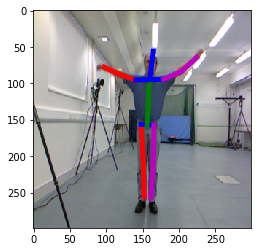

In [30]:
# sample frame from G3D dataset
visualise_pose_estimation('images/example_1.png', 'images/example_1_pose.jpg')

C:\Users\Yuhao\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\Yuhao\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


right ankle : 7.94%
right knee : 4.51%
right hip: 37.01%
left hip: 38.19%
left knee: 4.66%
left ankle: 9.76%
pelvis: 49.30%
thorax: 1.14%
upper neck: 1.09%
head top: 0.67%
right wrist: 27.90%
right elbow: 14.24%
right shoulder: 1.84%
left shoulder: 4.65%
left elbow: 34.12%
left wrist: 25.12%


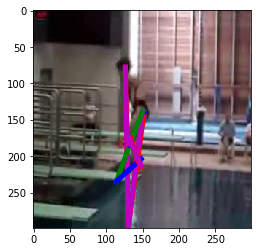

In [38]:
# sample frame from UCF11 dataset
visualise_pose_estimation('images/example_3.jpg', 'images/example_3_pose.jpg')

As you can see here, the pose estimation does not work as well in UCF11 dataset. This might explain the lower accuracy achieved in the final classification

C:\Users\Yuhao\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\Yuhao\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


right ankle : 1.88%
right knee : 6.99%
right hip: 2.57%
left hip: 4.11%
left knee: 5.61%
left ankle: 1.98%
pelvis: 2.98%
thorax: 1.66%
upper neck: 0.95%
head top: 2.74%
right wrist: 20.13%
right elbow: 6.89%
right shoulder: 1.98%
left shoulder: 2.30%
left elbow: 44.35%
left wrist: 38.46%


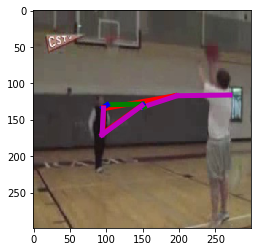

In [39]:
# sample frame from UCF11 dataset
visualise_pose_estimation('images/example_2.jpg', 'images/example_2_pose.jpg')

The pose estimation performs even worser when the subject doing the action is not in the center of the frame and when there are multiple subjects in the frame.

## Prediction
We will use LogReg model as the last layer for classification.

In [43]:
def predict_action(video_path, model):
    video_frames = read_video_frames(video_path)
    temporal_features = extract_features(video_frames)

    sample_features = []
    sample_features.append(temporal_features)
    sample_x =  np.array(sample_features, dtype='float32')

    # Predict
    sample_pred = model.predict(sample_x)
    # change the category here for different datasets
    print(UCF_11_CATEGORIES[sample_pred[0]]) 

## Predict Sample Videos on G3D Dataset
### Notice that the left and right are defined from the perspective of the viewer. 

In [32]:
sample_video_path = "samples/test_7.mp4"
predict_action(sample_video_path, logreg)
video = Video.from_file(sample_video_path)
video

Reading video frames from samples/test_7.mp4
Left Kick


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x03\xbdmoov\x00\x00\x00lmvhd\x00\x…

In [33]:
sample_video_path = "samples/test_6.mp4"
predict_action(sample_video_path, logreg)
video = Video.from_file(sample_video_path)
video

Reading video frames from samples/test_6.mp4
Right Kick


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x03\x89moov\x00\x00\x00lmvhd\x00\x…

In [34]:
sample_video_path = "samples/test_8.mp4"
predict_action(sample_video_path, logreg)
video = Video.from_file(sample_video_path)
video

Reading video frames from samples/test_8.mp4
Flap Arms


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x03\xf9moov\x00\x00\x00lmvhd\x00\x…

In [35]:
sample_video_path = "samples/test_9.mp4"
predict_action(sample_video_path, logreg)
video = Video.from_file(sample_video_path)
video

Reading video frames from samples/test_9.mp4
Left Punch


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x035moov\x00\x00\x00lmvhd\x00\x00\…

## Predict Sample Videos on UCF11 Dataset

In [44]:
sample_video_path = "samples/test_1.mp4"
predict_action(sample_video_path, logreg)
video = Video.from_file(sample_video_path)
video

Reading video frames from samples/test_1.mp4
horse_riding


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xecZmdat\x00\x…

In [45]:
sample_video_path = "samples/test_4.mp4"
predict_action(sample_video_path, logreg)
video = Video.from_file(sample_video_path)
video

Reading video frames from samples/test_4.mp4
soccer_juggling


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x11\x97moov\x00\x00\x00lmvhd\x00\x…

In [46]:
sample_video_path = "samples/test_5.mp4"
predict_action(sample_video_path, logreg)
video = Video.from_file(sample_video_path)
video

Reading video frames from samples/test_5.mp4
diving


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x06\xcbmoov\x00\x00\x00lmvhd\x00\x…

## Some Wrong Predictions on UCF11 Dataset

In [47]:
sample_video_path = "samples/test_3.mp4"
predict_action(sample_video_path, logreg)
video = Video.from_file(sample_video_path)
video

Reading video frames from samples/test_3.mp4
volleybal_spiking


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x08\xa3moov\x00\x00\x00lmvhd\x00\x…

In [48]:
sample_video_path = "samples/test_2.mp4"
predict_action(sample_video_path, logreg)
video = Video.from_file(sample_video_path)
video

Reading video frames from samples/test_2.mp4
diving


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x05\xf3moov\x00\x00\x00lmvhd\x00\x…

## Discussion

Our project was a great example of Transfer Learning. The model trained previously for human gait recognition was extended here to recognize general human actions. 

One advantage of our model for human action recognition was that it extracted only the spatial and temporal information of the human pose, thus excluding the background noises. It does not work well, as we had observed, on frames where the human subject was decentralized or partially blocked or when there were multiple subjects.

To further improve the classification accuracy especially on UCF11 and UCF101 datasets, we have to standardize the video frames so that the subject performing the action is centralized and at a profile view. As we have seen from the visualization of pose estimation, some frames were wrongly estimated leading to the inaccurate results. 

For future works, the natural extension of this project would be to enable real-time action recognition on video or camera stream. We would also be exploring the possibility of combining the current popular approaches with our model through Emsemble methods to see if better results could be achieved.